In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score, roc_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load data
X_train = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\X_train.csv')
X_test = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\X_test.csv')
y_train = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\y_train.csv').squeeze()
y_test = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\y_test.csv').squeeze()

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
#SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [7]:
#Logistic Regression with tuning
log_reg = LogisticRegression()
lr_params = {'C': [0.01, 0.1, 1, 10]}
lr_cv = RandomizedSearchCV(log_reg, lr_params, cv=3, n_iter=4, scoring='roc_auc', random_state=42)
lr_cv.fit(X_train_res, y_train_res)
best_lr = lr_cv.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
y_proba_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

In [5]:
# Support Vector Machine
svm = SVC(probability=True, random_state=42)
svm_params = {'C': [1], 'kernel': ['linear']}
svm_cv = RandomizedSearchCV(svm, svm_params, cv=3, n_iter=4, scoring='roc_auc', random_state=42)
svm_cv.fit(X_train_res[:20000], y_train_res[:20000])
y_pred_svm = svm_cv.predict(X_test_scaled)
y_proba_svm = svm_cv.predict_proba(X_test_scaled)[:, 1]

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [6]:
# k-Nearest Neighbors
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [5]}
knn_cv = RandomizedSearchCV(knn, knn_params, cv=3, n_iter=3, scoring='roc_auc', random_state=42, n_jobs=-1)
knn_cv.fit(X_train_res[:20000], y_train_res[:20000])
y_pred_knn = knn_cv.predict(X_test_scaled)
y_proba_knn = knn_cv.predict_proba(X_test_scaled)[:, 1]


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [8]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n📊 {name} Performance")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_true, y_proba):.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_true, y_proba):.2f})')



📊 Logistic Regression Performance
Confusion Matrix:
[[178579  42473]
 [  5834  24666]]
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88    221052
         1.0       0.37      0.81      0.51     30500

    accuracy                           0.81    251552
   macro avg       0.67      0.81      0.69    251552
weighted avg       0.90      0.81      0.84    251552

Accuracy:  0.8080
Precision: 0.3674
Recall:    0.8087
F1 Score:  0.5052
ROC AUC:   0.8925

📊 SVM Performance
Confusion Matrix:
[[218920   2132]
 [ 22609   7891]]
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95    221052
         1.0       0.79      0.26      0.39     30500

    accuracy                           0.90    251552
   macro avg       0.85      0.62      0.67    251552
weighted avg       0.89      0.90      0.88    251552

Accuracy:  0.9016
Precision: 0.7873
Recall:    0.2587
F1 Score:  0.3895
ROC AUC:   0.8879

📊 k-N

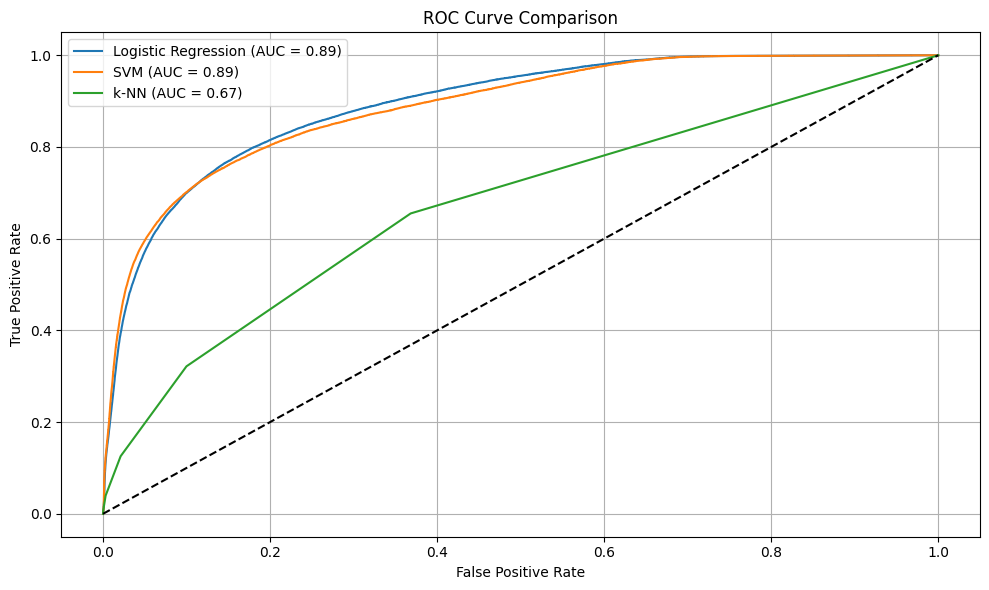

['C:\\Users\\Admin\\asset_quality_score\\outputs\\best_knn.pkl']

In [9]:
#Plot ROC Curves
plt.figure(figsize=(10, 6))
evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("SVM", y_test, y_pred_svm, y_proba_svm)
evaluate_model("k-NN", y_test, y_pred_knn, y_proba_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Step 10: Save Models
joblib.dump(best_lr, 'C:\\Users\\Admin\\asset_quality_score\\outputs\\best_logistic_regression.pkl')
joblib.dump(svm_cv.best_estimator_, 'C:\\Users\\Admin\\asset_quality_score\\outputs\\best_svm.pkl')
joblib.dump(knn_cv.best_estimator_, 'C:\\Users\\Admin\\asset_quality_score\\outputs\\best_knn.pkl')
